# This note book is written by Quantao quantaosun@gmail.com 


Please be aware that, the priority or my top consideration is to get a relative FEP up and running, when it come to the precision, it is my second consideration, so I have to tell you that, the way I modified the NAMD conf files is directed by this logic. It is simple and fairly easy to run the simulation, but the ability of correcting or reducing the so called "end point catastrophe" is limited as I have not introduce more lambda windows when it get 
closer to 0 or 1. But that shouldn't stop this whole procedure being a good FEP 
method given that the commercial FEP is very expensive like the Schdrodinger's FEP plus. In a validation I carried out for a -2.9 kcal/mol experimental result, this work flow gived a number of -4.0 kcal/mol in a relative short simulation.
**If you do care about the end point catastrophe a lot, please use the default NAMD conf file instead of the version I showed in this note book.**

Two things are making FEP still a complex and challenging task, it is far less applied used compared to molecular docking. The number one reason is the set up for FEP input requires expert knowledge in both chemistry and coding, many detailed things need to be addressed like the protein structure errors and careful ligand alignment. Number two would be the high computing resources required as much as a thousand times more than a general docking procedure.

In this notebook, we will discuss how to set up a ligand mutation FEP step by step based on a web server called Feprepare, note, this web server is NAMD supported and not suitable for other simulation packages like Gromacs. Only the input for the Feprepare listed here without the output, due to the supper long file format, it is advised that you could read this blog with your output at hand.

Molecular dynamic package NAMD is one of the most widely used free molecular dynamic software, especially in biochemistry area,it usually use with VMD. NAMD for now can only runs on Linux, VMD can runs on multiple platforms including Windows.

This tutorial is for FEP validation purpose mainly towards NAMD/2.13-mpi, it also provide a chance to test the reliability of webserver Feprepare Feprepare, which is to help users to generate input files for namd. You are expected to have basic knowledge about bash language for simple coding.

In a typical FEP calculation, a 16 or 32 lambda window would be applied. Here we use 16 lambada. The initial structures downloaded from PDB website, Schrodinger Maestro was used to quickly prepare the protein structure, and align the Ligand by its flexible ligand alignment.

We are going to use two protein-ligand structures dowloaded from the Protein Data Bank, namely 1MQ5 and 1MQ6, with ligand XLC and XLD bound.



# Installation of the software

In [ ]:
# Download the NAMD binary
#!wget https://www.ks.uiuc.edu/Research/namd/2.14/download/946183/NAMD_2.14_Linux-x86_64-multicore-CUDA.tar.gz

In [ ]:
# Extract the file
# !tar -zxf /content/NAMD_2.14_Linux-x86_64-multicore-CUDA.tar.gz
#!tar -zxf NAMD_2.14_Linux-x86_64-multicore-CUDA.tar.gz

In [ ]:
#!tar -zxf charmm-gui-solution.tgz

In [ ]:
#!pwd
#!mkdir namd_result
#%cd namd_result/

# Step 1: Files set up for LigParGen

Open maestro

File > Get PDB “1MQ5“ Download （the same for 1MQ6） Left click > split > by molecule (the same for 1MQ6) only keep the protein and ligands.

only three structures lefted, which is protein and ligand 1 and ligand 2.

Delete other columns Group > “group selected entries & Groups” > Create Group

File > save project as

There are no H atoms in raw crystal structures, so we need to add H to both the protein and ligands.

Protein preparation > “assign bond orders, add hydrogens, create disulfide bonds. Delete waters beyond 5 angstroms from het group” > Preprocess > problems OK.

you don't have to do the minimization, but if your protein has missing loops or missing side chains, you need to fix it by ticking the corresponding option and run the preparation properly.

(do the same for XLC and XLD ligands) Delete the old structures in time.

flexible ligand alignment > common scaffold alignment > maximum common substructures

file > export , export the protein.pdb, XLC.pdb and XLD.pdb respectively to a folder.
Then open the protein.pdb and delete the hydrogens, this is necessary for using in the fepreapre site.

Alternatively, if your reference ligand is from PDB while mutant ligand is derived from 3D builder of Maestro, it is ok to prepare the reference by prtotein preparation while the mutant prepared by the LigPrep.


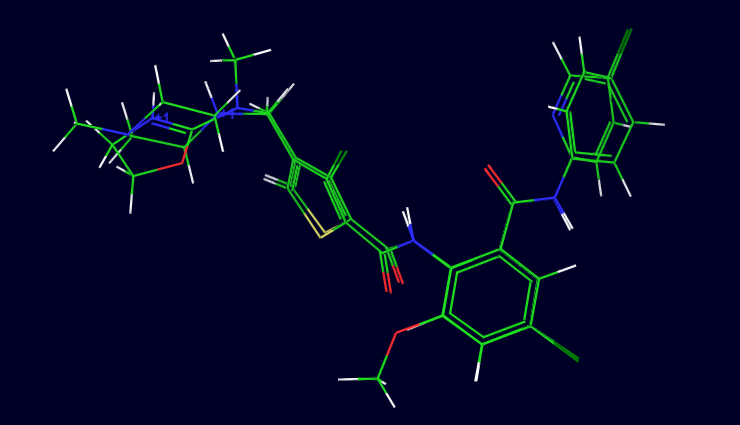

# Step2: Files uploaded to LigParGen

Sever LigParGen is a web-based service that provides force field (FF) parameters for organic molecules or ligands, offered by the Jorgensen group.
http://zarbi.chem.yale.edu/ligpargen/ 

Sever LigParGen is a web-based service that provides force field (FF) parameters for organic molecules or ligands, offered by the Jorgensen group.
Upload XLC.pdb to LigParGen, > submit > download *.rtf and *.prm for charm/namd

Upload XLD.pdb, do the same thing.

Note since the NAMD default charmm force field can recognize all amino acids, there is no need to upload protein.pdb.

Choose 0 optimization iterations, choose the 1.14*CM1A charge model. Remember that the three files you need are the PDB file, PRM and RTF, the PDB should be 
downloaded as well, you don't want to use the original PDB file from masestro any more. 

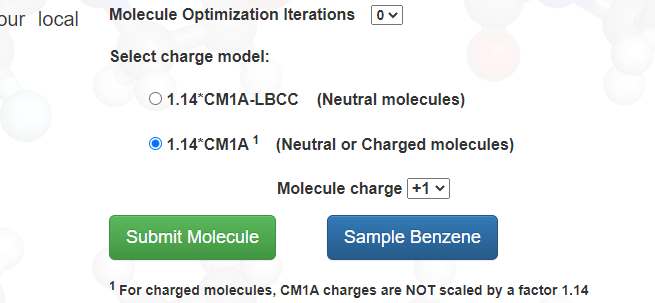

# Step3 :Upload output files from LigParGen to Feprepare

Upload xlc.pdb, xlc.rtf, xlc.prm as reference, upload xld.pdb,xld.rtf,xld.prm as mutant. Upload protein.pdb (1MQ5) as protein.pdb, submit and after minutes, the job should be done. Download the output files as files.zip.

Note that, the protein.pdb need to have NO hydrogens. The reference.pdb and mutant.pdb should come from LigPargen instead of Maestro.

# Step4: Transport files.zip to remote cluster or wo online platform like colab, or to AI studio of Baidu


Fep calculation need a lot computatinal resources, you are supposed to have access to some kind of cluster or super computer which instlalled with NAMD/2.13-mpi. Use SSH command or use SFTP tools like FileZilla to transfer to your remote host. Log into your remonte host

This notebook assumes one use the NAMD on a cluster, not on colab. If you wish to use it on clolab, there are might be places later you need to fit in.

In [ ]:
%%bash
mkdir fep 
mv files.zip fep
cd fep
unzip files.zip
cd complex/ 
ls

There are two branch legs, namely the "complex" and "solvent" branch, we are going to calculate the free energy changee for both of them, now we are in "complex" folder.

# Step 5: Modify NAMD configuration file or .namd file.

Now it is time to modify the NAMD configuration file since there seem incomplete parameters listed by Feprepare Sever. Caution! This part is tricky. Though there is already some configuration file existed in the current folder but they are found incomplete or some other tiny errors. Please double-check the three following things.

First
more parameter files need to be added to the nvt_equill.namd/npt_equil.namd as well as the md_forward.namd. Here I just copy a whole pack of parameter files originally from Charmm-Gui > Input generator > relative ligand binder. What needs to be done is copy the so-called “ toppar” file from Charm-GUI and put it in /srv/scratch/myfolder. Make sure this path is properly defined in the *namd file.
Second
add the ‘updated.prm" as well in the "parameter" list as well, ohterwise there will be an error "XXX.atom unrecognized" happening.
Third
Also, make sure your “toppar” folder contains this modified “water_ions.mod.str” otherwise another infamous atom type OT not found will find you !!!
Note it was found there might be a key mistake from the default *.namd file from Feprepare, that is the default value for "alchfille" was ionized.fep, but I have found the ionized.fep B column was not defining the -1 and 1 beta for those atoms need to be perturbated, while the ionzed_comple.fep should be the right one. If you want to know more, the Feprpare manual should be read.

Last, remember, you don’t need to set any lambda at this equilibrate stage, set them all to 0.0, 0.0, 0.0.

You could generate the "file.zip" from Feprepare web server based on your ligands of interest before using the scripts. Another two files are provided here for free downloading, all the extraction codes are 9999. One is the toppar file which contains all the topology files need for the simulation, the other is the parameter patch file .

After the three files ready, to use these two scripts, in the complex or solvent directory.(you need to modify the namd path to your NAMD installation location)

 $

```

 chmod +x complex-leg-patch.sh
                  $ ./complex-leg-patch.sh
```


topology files: https://pan.baidu.com/s/1LKrbaeZv9EWYBAfIdTFXCA/?_at_=1618992733630 9999

parameter patch file:https://pan.baidu.com/s/1Vdc9l-dYGCEETmye-mKGIg/ extraction code 9999

Note that, I have noticed some changes of website Feprepare, it is up the developers of the Feprepare to decide what kind of return files or what kind of files.zip you get, so I can not guaretee that the folling script is always properly fit into what you have or will get from feprepare, plese feel free to change the folder names or any other changes you have noticed.

This script is written in 2020, modified in 2021.

Also, if you run this FEP on colab or AI studio, you need to change the namd2 running command lines to adpat to your platform, the example next only be siutable on a cluster installed with NAMD/2.13-mpi, and assume that you have already loaded the necessary envionment like mpi and charmm related modules on such cluster.

**complex-leg-patch.sh**

In [ ]:
#!/bin/bash
# This script is written for the purpose to do ligand mutation free energy perturbation. 
# I assume you use the web server "Feprepare" to generate "all" necessary input files
# towards NAMD simulation. This script can help to change the "lambda by lambda"
# simulation sequence to "all lambda in one" simulation, making the simulation easier
# to handle and analysis later. The directory location to run this script should be 
# the "complex" or "solvent", respectively. This one is for complex leg.
##email to quantaosun@gmail.com if there is any issues or errors. 

# It should be advised; the author of this script only have preliminary knowledge of 
# coding, so use this script at your own risk !

############ NVT script modification ##################################
cp conf_complex/nvt_equil.namd ./
head -n 13 nvt_equil.namd > output1
cat parameter_patch.txt >> output1
tail -n +14 nvt_equil.namd > output2
sed -i 's/ionized.fep/ionized_complex.fep/' output2
cat output2 >> output1
mv output1 nvt_equil_modi.namd


############ NPT script modification #####################################
cp conf_complex/npt_equil.namd ./
head -n 13 npt_equil.namd > output3
cat parameter_patch.txt >> output3
tail -n +14 npt_equil.namd > output4
sed -i 's/ionized.fep/ionized_complex.fep/' output4
cat output4 >> output3
mv output3 npt_equil_modi.namd

############### Production script modification #################################

cp conf_complex/md_forward_1.namd ./

tail -n 3 md_forward_1.namd > tmp2.txt
echo "alchEquilSteps          0
    set numSteps            500000       ; # 0.5 ns as a total

   runFEP 0.0 1.0 0.0625 $numSteps" > tmp2.txt                  # overwrite the original Lambda0 Lambda2 format, 16 lambda windows

cat tmp2.txt >> md_forward_1.namd

#To uncomment lines 139 through 141 to close the one by one simulation.

sed -i '139,141 s/^/#/' md_forward_1.namd                         #double check the line numbers.

head -n 123 md_forward_1.namd > outputA
tail -n +124 md_forward_1.namd > outputB
echo "source     ../fep.tcl" >> outputA
cat outputB >> outputA
mv outputA md_forward_1.namd
#################### To substitute the alchFile ##############                                                 
head -n 13 md_forward_1.namd > output5
cat parameter_patch.txt >> output5
tail -n +14 md_forward_1.namd > output6
sed -i 's/ionized.fep/ionized_complex.fep/' output6                  # correct the B column with -1
sed -i '/^alchDecouple/s/off/yes/' output6                            # turn on the "alchDecouple"
cat output6 >> output5
mv output5 md_forward_modi.namd

########Running the job#################################

qsub -I -l select=1:ncpus=32:mem=40gb,walltime=10:00:00 -M your_email@.. -m aeb
cd $PBS_O_WORKDIR
module load intel/18.0.1.163 openmpi/3.1.2-intel namd/2.13-mpi

export Honey_NAMD=/apps/namd/2.13-mpi/arch/Linux-x86_64-icc   # this need to be modified

###################################################################
mpirun --oversubscribe -np 4 $Fuck_NAMD/namd2 +ppn 7 nvt_equil_modi.namd > nvt_equil_modi.out

#NPT###############################################################

mpirun --oversubscribe -np 4 $Fuck_NAMD/namd2 +ppn 7 npt_equil_modi.namd > npt_equil_modi.out

# Production#######################################################

mpirun --oversubscribe -np 4 $Fuck_NAMD/namd2 +ppn 7 md_forward_modi.namd > md_forward_modi.out


**solvent-leg-patch.sh**
To use these two scripts, in the complex or solvent directory.



```
 chmod +x solvent-leg-patch.sh
                  ./solvent-leg-patch.sh
```



In [ ]:
#!/bin/bash
# This script is written for the purpose to do ligand mutation free energy pertubation. 
# I assume you use the web server "Feprepare" to generate "all" necessary input files
# towards NAMD simlation. This script can help to change the "lambda by lambda"
# simulation sequence to "all lambda in one" simulation, making the simulation easier
# to handle and analysis later. The directory location to run this script should be 
# the "complex" or "solvent", respectively. This one is for solvent leg.
##email to quantaosun@gmail.com if there is any issues or errors. 

# It should be advised; the author of this script only have preliminary knowledge of 
# coding, so use this script at your own risk !

############ NVT script modification ##################################
cp conf_solvent/nvt_equil.namd ./
head -n 13 nvt_equil.namd > output1
cat parameter_patch.txt >> output1
tail -n +14 nvt_equil.namd > output2
sed -i 's/ionized.fep/ionized_solvent.fep/' output2
cat output2 >> output1
mv output1 nvt_equil_modi.namd


############ NPT script modification #####################################
cp conf_solvent/npt_equil.namd ./
head -n 13 npt_equil.namd > output3
cat parameter_patch.txt >> output3
tail -n +14 npt_equil.namd > output4
sed -i 's/ionized.fep/ionized_solvent.fep/' output4
cat output4 >> output3
mv output3 npt_equil_modi.namd

############### Production script modification #################################

cp conf_solvent/md_forward_1.namd ./

tail -n 3 md_forward_1.namd > tmp2.txt
echo "alchEquilSteps          0
    set numSteps            500000       ; # 0.5 ns as a total

   runFEP 0.0 1.0 0.0625 $numSteps" > tmp2.txt                  # overwrite the original Lambda0 Lambda2 format, 16 lambda windows

cat tmp2.txt >> md_forward_1.namd

#To uncomment lines 139 through 141 to turn off the one by one simulation:

sed -i '139,141 s/^/#/' md_forward_1.namd                         #double check the line numbers.

head -n 123 md_forward_1.namd > outputA
tail -n +124 md_forward_1.namd > outputB
echo "source     ../fep.tcl" >> outputA
cat outputB >> outputA
mv outputA md_forward_1.namd
#################### To substitute the alchFile ##############                                                 
head -n 13 md_forward_1.namd > output5
cat parameter_patch.txt >> output5
tail -n +14 md_forward_1.namd > output6
sed -i 's/ionized.fep/ionized_solvent.fep/' output6                  # correct the B column with -1
sed -i '/^alchDecouple/s/off/yes/' output6                            # turn on the "alchDecouple"
cat output6 >> output5
mv output5 md_forward_modi.namd

########Running the job#################################

qsub -I -l select=1:ncpus=32:mem=40gb,walltime=10:00:00 -M your_email@.. -m aeb
cd $PBS_O_WORKDIR
module load intel/18.0.1.163 openmpi/3.1.2-intel namd/2.13-mpi

export Honey_NAMD=/apps/namd/2.13-mpi/arch/Linux-x86_64-icc # this need to be modified.

###################################################################
mpirun --oversubscribe -np 4 $Fuck_NAMD/namd2 +ppn 7 nvt_equil_modi.namd > nvt_equil_modi.out

#NPT###############################################################

mpirun --oversubscribe -np 4 $Fuck_NAMD/namd2 +ppn 7 npt_equil_modi.namd > npt_equil_modi.out

# Production#######################################################

mpirun --oversubscribe -np 4 $Fuck_NAMD/namd2 +ppn 7 md_forward_modi.namd > md_forward_modi.out




# After the calculation is done, please use the "complex - solvent" to obtain the FEP ddG value

Always keep in mind that, for the FEP in NAMD, and any other free packages like Gromacs or potentially OpenMM, Sire etc., the input preparation may even harder and more important than the running process itself. So, be patient and have fun, and good luck !